In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt
import os
import seaborn as sns

2023-08-28 11:00:04.888194: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Número de filas y columnas: (2557, 1) 

Tipo de datos:
 Load    int64
dtype: object 

Head:
                   Load
Date                  
2015-01-01  5686686080
2015-01-02  6752007030
2015-01-03  6605796020
2015-01-04  6273091530
2015-01-05  6760770300 



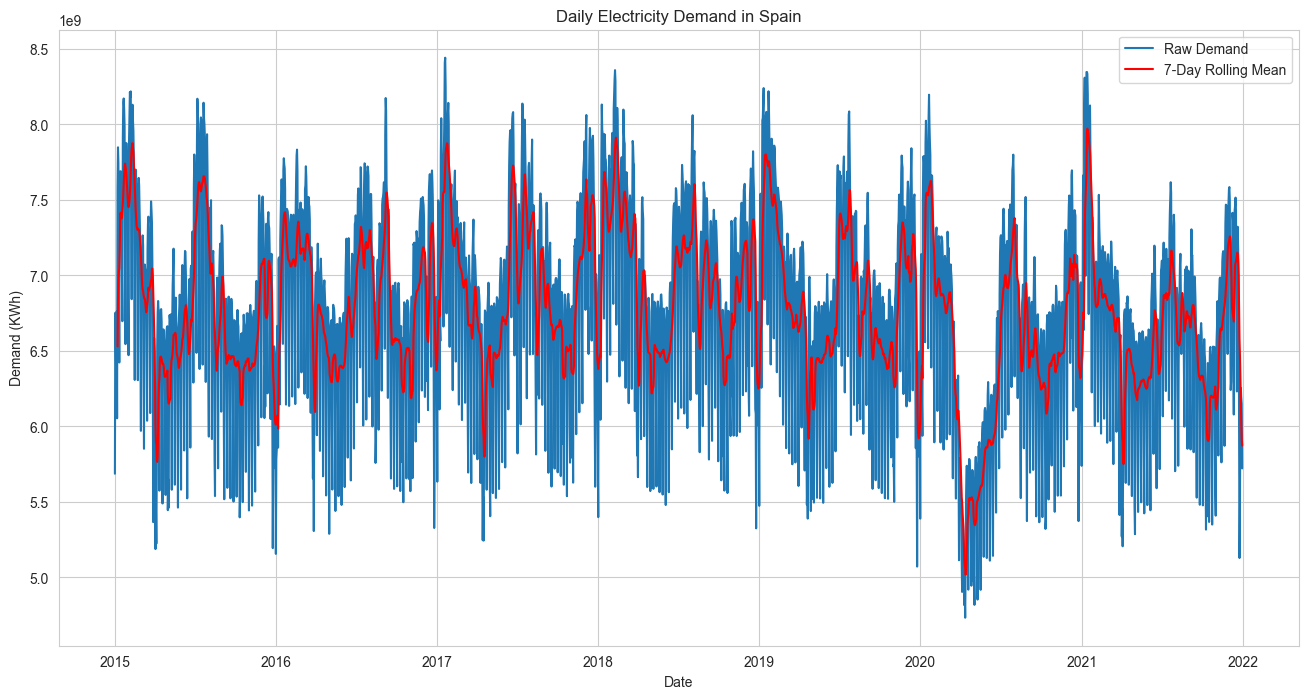

In [2]:
# Load dataset
path = os.getcwd()
fichero_DemandaDiaria = os.path.join(path, 'DemandaDiaria_KWh_2015-2021.csv')

# Read the data
data = pd.read_csv(fichero_DemandaDiaria, sep=";")
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Check the data
print("Número de filas y columnas:", data.shape, "\n")
print("Tipo de datos:\n", data.dtypes, "\n")
print("Head:\n", data.head(), "\n")

# Graph the data
sns.set_style("whitegrid")
rolling_mean = data['Load'].rolling(window=7).mean()
plt.figure(figsize=(16, 8))
plt.title('Daily Electricity Demand in Spain')
plt.xlabel('Date')
plt.ylabel('Demand (KWh)')
plt.plot(data.index, data['Load'], label='Raw Demand')
plt.plot(data.index, rolling_mean, color='red', label='7-Day Rolling Mean')
plt.legend(loc='best')
plt.show()

In [3]:
# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Load'].values.reshape(-1, 1))

# Split the data into training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Create sequences of length 'sequence_length' to use as input data
def create_sequences(dataset, sequence_length_scope):
    X, y = [], []
    # Iterate over the dataset and create sequences of length 'sequence_length'
    for i in range(len(dataset) - sequence_length_scope):
        # Add a sequence of length 'sequence_length' to X
        X.append(dataset[i:i + sequence_length_scope, 0])
        # Add the next data point after each sequence of length 'sequence_length' to y
        y.append(dataset[i + sequence_length_scope, 0])
    # Convert list to array
    return np.array(X), np.array(y)

sequence_length = 10  # Length of the sequence for each input point
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Check the shape of the training sequences
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2035, 10)
y_train shape: (2035,)
X_test shape: (502, 10)
y_test shape: (502,)


In [4]:
# Reshape de los datos para LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [5]:
def fitness_function(params):    
    units1 = params[:len(params)//2].astype(int)
    units2 = params[len(params)//2:].astype(int)

    train_rmse = []
    test_rmse = []
    train_mae = []
    test_mae = []
    train_mrae = []
    test_mrae = []


    for i in range(len(units1)):  # Utiliza units1.shape[0] para iterar sobre los elementos de units1
        print('Iteration: ', i, ' of ', len(units1))
        _model = Sequential()
        _model.add(Conv1D(filters=units1[i], kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
        _model.add(MaxPooling1D(pool_size=2))
        _model.add(Conv1D(filters=units2[i], kernel_size=3, activation='relu'))
        _model.add(MaxPooling1D(pool_size=2))
        _model.add(Flatten())
        _model.add(Dense(units=1))
        
        _model.compile(optimizer='adam', loss='mean_squared_error')
        _model.fit(X_train, y_train, epochs=20, batch_size=15, verbose=0)

        # Realizar predicciones
        train_pred = _model.predict(X_train)
        test_pred = _model.predict(X_test)
        train_predictions = scaler.inverse_transform(train_pred.reshape(-1, 1))
        test_predictions = scaler.inverse_transform(test_pred.reshape(-1, 1))
        y_train_unscaled = scaler.inverse_transform( y_train.reshape(-1,1) )
        y_test_unscaled = scaler.inverse_transform( y_test.reshape(-1,1) )

        # Calcular métricas de rendimiento
        train_rmse =  np.append( train_rmse, np.sqrt(np.mean((y_train_unscaled - train_predictions) ** 2 )) )
        test_rmse = np.append( test_rmse, np.sqrt(np.mean((y_test_unscaled - test_predictions) ** 2 )) )
        train_mae = np.append ( train_mae, np.mean(np.abs(y_train_unscaled - train_predictions) ) )
        test_mae = np.append( test_mae, np.mean(np.abs(y_test_unscaled - test_predictions)) )
        mean_load = data['Load'].mean()
        train_mrae = np.append( train_mrae, np.mean(np.abs((y_train_unscaled - train_predictions) / mean_load)) )
        test_mrae = np.append( test_mrae, np.mean(np.abs((y_test_unscaled - test_predictions) / mean_load) ) )
        
    return test_mrae

In [6]:
from datetime import datetime


class GreyWolfOptimizer:
    """
    Grey Wolf Optimizer (GWO) implementation.
    Note: This implementation is designed for minimization problems.
    """

    def __init__(self, n_agents, function, lb, ub, dimension, n_iterations):
        """
        :param n_agents: Number of agents (wolves)
        :param function: Fitness function to be minimized
        :param lb: Lower bound of the search space
        :param ub: Upper bound of the search space
        :param dimension: Dimension of the search space
        :param n_iterations: Number of iterations
        """
        self.n_agents = n_agents
        self.function = function
        self.lb = lb
        self.ub = ub
        self.dimension = dimension
        self.n_iterations = n_iterations
        self.agents = np.random.uniform(self.lb, self.ub, (self.n_agents, self.dimension))
        self.alpha, self.beta, self.delta, self.fitness_alpha, self.alpha_id = self._get_abd()
        self.global_best = self.alpha
        self.fitness_global_best = self.fitness_alpha
        self.global_best_iter = 0
        self.global_best_id = self.alpha_id + 1
        self.start_time = datetime.now()

    def _get_abd(self):
        """
        Function to identify the three best wolves (alpha, beta, delta)
        :return: The positions and fitness of the three best wolves
        """
        fitness = [(self.function(self.agents[i]), i) for i in range(self.n_agents)]
        fitness.sort()
        alpha, beta, delta = [self.agents[fitness[i][1]] for i in range(3)]
        fitness_alpha = fitness[0][0]
        alpha_id = fitness[0][1]
        return alpha, beta, delta, fitness_alpha, alpha_id

    def optimize(self):
        """
        Main optimization loop
        :return: The global best position and its fitness
        """
        for t in range(self.n_iterations):
            a = 2 - 2 * t / self.n_iterations  # Update the 'a' parameter

            # Compute the position update components for all agents
            D_alpha, D_beta, D_delta = [self._compute_position_update(a, wolf) for wolf in [self.alpha, self.beta, self.delta]]

            # Update the positions of all agents
            self.agents = (D_alpha + D_beta + D_delta) / 3
            self.agents = np.clip(self.agents, self.lb, self.ub)  # Clip to the search space bounds

            # Update alpha, beta, delta
            self.alpha, self.beta, self.delta, self.fitness_alpha, self.alpha_id = self._get_abd()

            # If a better alpha is found, update the global best position and its fitness
            if self.fitness_alpha < self.fitness_global_best:
                self.global_best = self.alpha
                self.fitness_global_best = self.fitness_alpha
                self.global_best_iter = t + 1
                self.global_best_id = self.alpha_id + 1

            # Print the current iteration results
            elapsed_time = datetime.now() - self.start_time
            print(f"Iteration {t+1}: Global best position: {self.global_best}, fitness: {self.fitness_global_best}, found by agent {self.global_best_id} in iteration {self.global_best_iter}, elapsed time: {elapsed_time}")

        return self.global_best, self.fitness_global_best

    def _compute_position_update(self, a, wolf):
        """
        Compute the position update for a given wolf
        :param a: The 'a' parameter
        :param wolf: The position of the wolf
        :return: The position update
        """
        r1 = np.random.random((self.n_agents, self.dimension))
        r2 = np.random.random((self.n_agents, self.dimension))
        A = 2 * r1 * a - a
        C = 2 * r2
        D = abs(C * wolf - self.agents)
        return wolf - A * D


In [7]:
# Define the search space
lb = [30, 30]
ub = [50, 50]

# Define the GWO parameters
n_agents = 5  # Number of agents
n_iterations = 10  # Number of iterations

# Create an instance of the GreyWolfOptimizer class
gwo = GreyWolfOptimizer(n_agents, fitness_function, lb, ub, 2, n_iterations)

# Run the GWO algorithm
best_position, _ = gwo.optimize()

# Obtener los mejores hiperparámetros encontrados
best_units1 = best_position[0].astype(int)
best_units2 = best_position[1].astype(int)
print('Best units1: ', best_units1)
print('Best units2: ', best_units2)

# Crear el modelo LSTM con los mejores hiperparámetros encontrados
model = Sequential()

# Primera capa CNN (filters -> Optimizado con PSO, número de filtros, kernel_size -> Tamaño de la ventana, activation -> Función de activación, input_shape -> Forma de los datos de entrada)
model.add(Conv1D(filters=best_units1, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
# Capa de pooling (reducción de dimensionalidad)
model.add(MaxPooling1D(pool_size=2))

# Segunda capa CNN (filters -> Optimizado con PSO, número de filtros, kernel_size -> Tamaño de la ventana, activation -> Función de activación)
model.add(Conv1D(filters=best_units2, kernel_size=3, activation='relu'))
# Capa de pooling (reducción de dimensionalidad)
model.add(MaxPooling1D(pool_size=2))

# Capa de aplanamiento (flatten)
model.add(Flatten())

# Capa densa (units: Número de neuronas, activation: Función de activación)
model.add(Dense(units=1))

# Compilar el modelo (optimizer: Algoritmo de optimización, loss: Función de pérdida)
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0) 

Iteration:  0  of  1
16/16 [==============================] - 0s 1ms/step
Iteration:  0  of  1
16/16 [==============================] - 0s 1ms/step
Iteration:  0  of  1
16/16 [==============================] - 0s 1ms/step
Iteration:  0  of  1
16/16 [==============================] - 0s 1ms/step
Iteration:  0  of  1
16/16 [==============================] - 0s 1ms/step
Iteration:  0  of  1
16/16 [==============================] - 0s 1ms/step
Iteration:  0  of  1
16/16 [==============================] - 0s 1ms/step
Iteration:  0  of  1
16/16 [==============================] - 0s 1ms/step
Iteration:  0  of  1
16/16 [==============================] - 0s 1ms/step
Iteration:  0  of  1
16/16 [==============================] - 0s 1ms/step
Iteration 1: Global best position: [39.0258359  48.01149811], fitness: [0.02471422], found by agent 1 in iteration 0, elapsed time: 0:00:21.472990
Iteration:  0  of  1
16/16 [==============================] - 0s 1ms/step
Iteration:  0  of  1
16/16 [===========

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get predictions
y_pred = model.predict(X_test)

# Invert the normalization for y_pred and y_test
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test_original, y_pred_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

# Calculate MRAE (Mean Absolute Percentage Error)
mrae = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

# Print metrics
print('MAE: {:,.2f}'.format(mae))
print('RMSE: {:,.2f}'.format(rmse))
print('MRAE: {:,.2f} %'.format(mrae))

16/16 [==============================] - 0s 3ms/step
MAE: 173,592,612.76
RMSE: 260,843,774.28
MRAE: 2.65 %


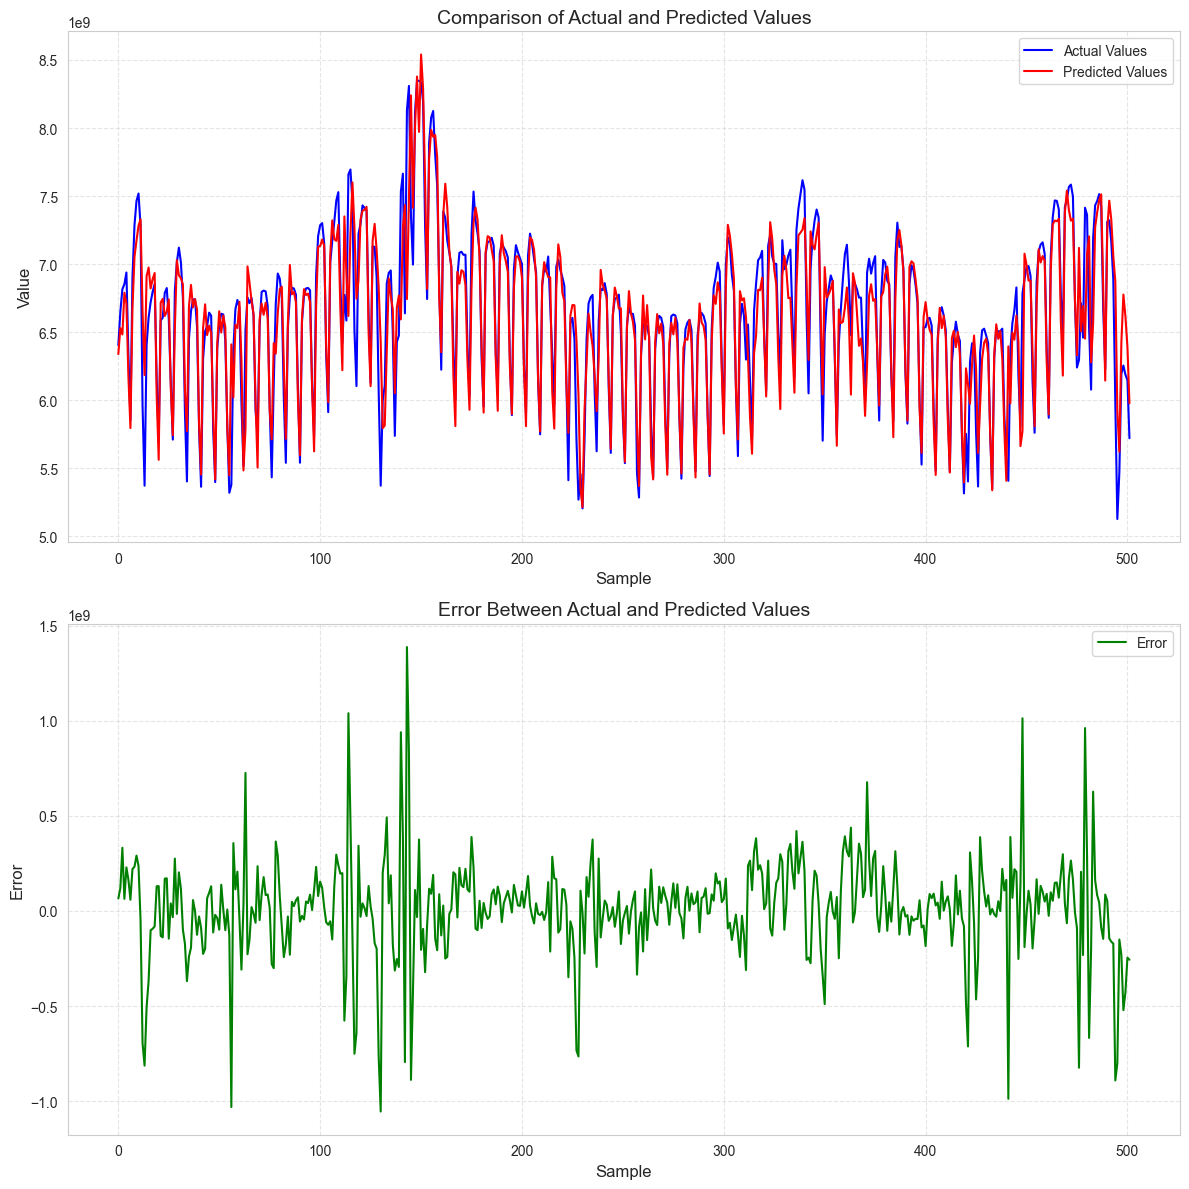

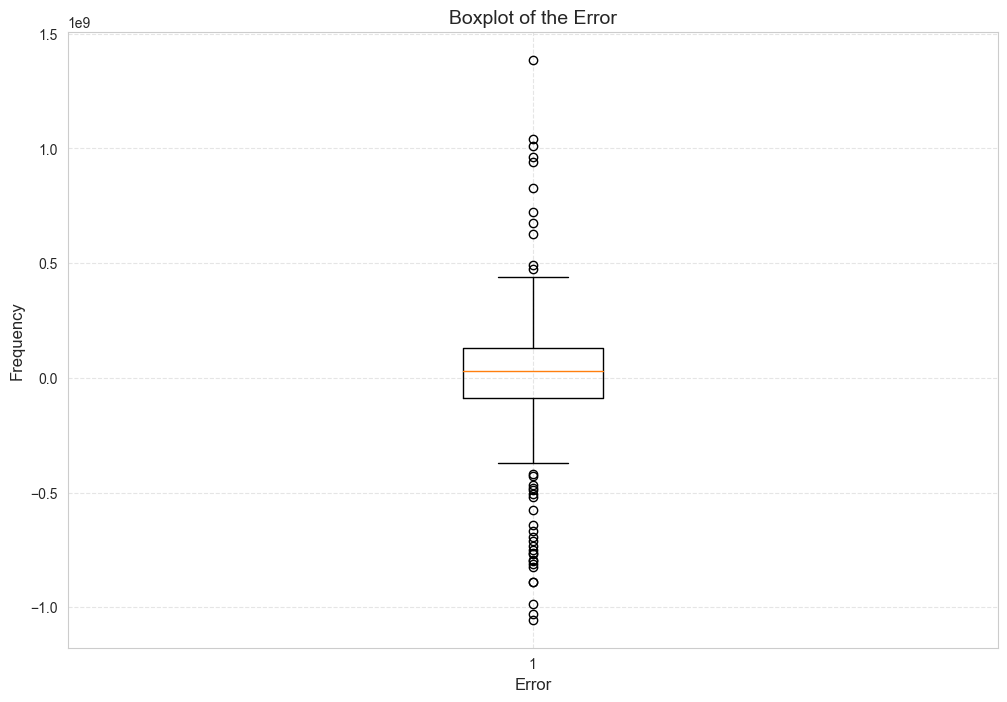

In [9]:
# Calculate the error between actual and predicted values
error = y_test_original - y_pred_original

# Create a figure and a set of subplots (2 subplots)
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the actual vs predicted values in the first subplot
axes[0].plot(y_test_original, label='Actual Values', color='blue')
axes[0].plot(y_pred_original, label='Predicted Values', color='red')
axes[0].set_xlabel('Sample', fontsize=12)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].set_title('Comparison of Actual and Predicted Values', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot the error in the second subplot
axes[1].plot(error, label='Error', color='green')
axes[1].set_xlabel('Sample', fontsize=12)
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_title('Error Between Actual and Predicted Values', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Show the plots
plt.tight_layout()
plt.show()

# Boxplot of the error
plt.figure(figsize=(12, 8))
plt.boxplot(error)
plt.xlabel('Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Boxplot of the Error', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()